# Computer Vision I: Variational Methods

## Exercise Sheet 1

Download the archive vmcv ex01.zip and unzip it on your home folder. In there should be a file named coins.png.

(Place in same directory as this notebook)

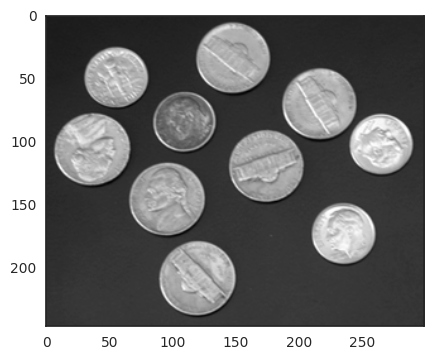

In [72]:
import numpy as np
from skimage.io import imread
import seaborn as sns
from pylab import *
%matplotlib inline

sns.set_style("white")

f = imread("vmcv_ex01/coins.png")
imshow(f, cmap="gray")
show()

Compute the convolution of the image with a Gaussian kernel. In theory, the Gaussian distribu-
tion is nonzero everywhere, however in practice we restrict ourself to truncated kernels. Set the
radius of the kernel to $r = \text{ceil}(3 \sigma)$.

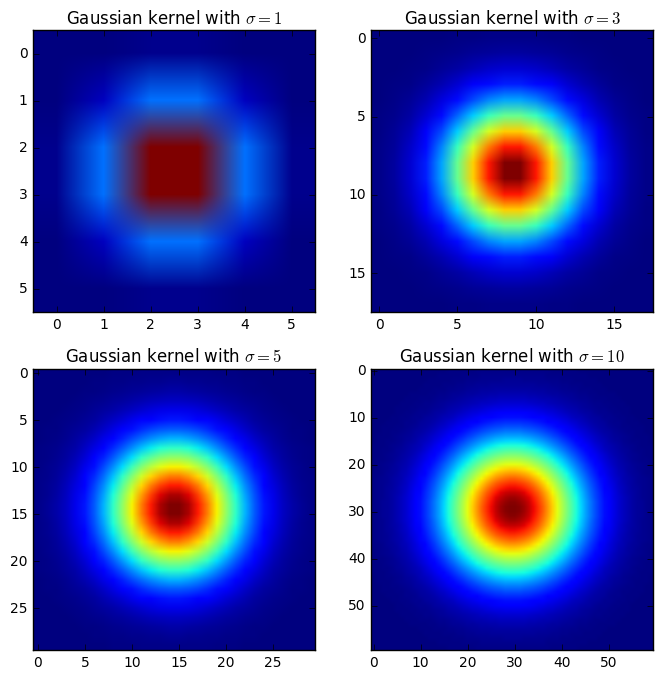

In [21]:
def gaussian_kernel(sigma):
    r = int(np.ceil(sigma*3))
    m, n = np.meshgrid(np.linspace(-r,r,2*r),
                       np.linspace(-r,r,2*r))
    w = np.exp(-(m**2 + n**2)/(2 * sigma**2))
    return w / w.sum()

i = 1
figure(figsize=(8,8))
for sigma in [1,3,5,10]:
    subplot(2,2,i)
    i += 1
    imshow(gaussian_kernel(sigma))
    title("Gaussian kernel with $\sigma=%d$" % (sigma,))
show()

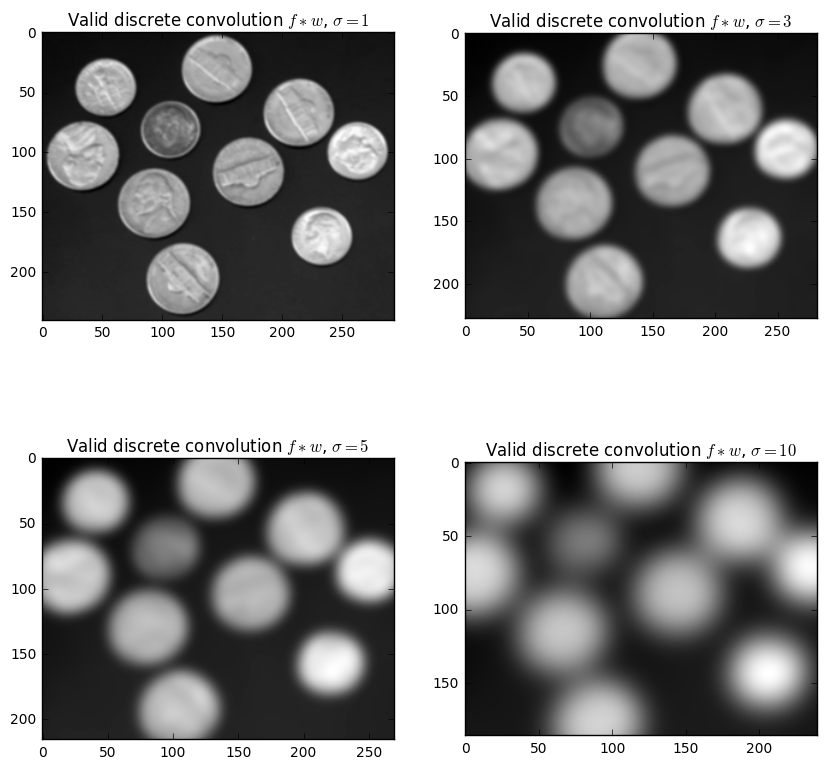

In [45]:
def conv2d(f, w):
    r = int(w.shape[0] // 2)
    w_,h_ = f.shape
    g = np.zeros((w_ - 2*r, h_ - 2*r)) #crop border regions

    for i in range(r, f.shape[0]-r):
        for j in range(r, f.shape[1]-r):
            g[i-r, j-r] = (w * f[i-r:i+r, j-r:j+r]).sum()
    return g

figure(figsize=(10,10))
i = 1
for sigma in [1,3,5,10]:
    subplot(2,2,i)
    i += 1
    w = gaussian_kernel(sigma)
    imshow(conv2d(f, w), cmap="gray")
    title("Valid discrete convolution $f * w$, $\sigma=%d$" % (sigma,))
    
show()

Let $W$ and $H$ denote respectively the width and height of the input image $f$. Compute the the gradient of the image using the discretization scheme of forward differences:

$$
(\partial_x^+ f)_{i, j} = 
\begin{cases}
f_{i+1,j} - f_{i,j} \quad \text{ if } i < W\\
0 \quad i = W\\
\end{cases}
$$

and 

$$
(\partial_y^+ f)_{i, j} = 
\begin{cases}
f_{i+1,j} - f_{i,j} \quad \text{ if } j < H\\
0 \quad j = H\\
\end{cases}
$$

Notice that the boundary values of the gradient are set to zero.

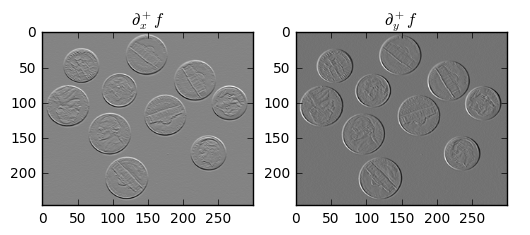

In [28]:
def grad(f):
    dfdx = np.zeros_like(f)
    dfdy = np.zeros_like(f)
    dfdx[:-1,:]  = f[1:,:] - f[:-1,:]
    dfdy[:, :-1] = f[:,1:] - f[:,:-1]
    return dfdx, dfdy

dfdx, dfdy = grad(f)

subplot(1,2,1)
imshow(dfdx, cmap="gray")
title("$\partial_x^+ f)$")
subplot(1,2,2)
imshow(dfdy, cmap="gray")
title("$\partial_y^+ f)$")
show()

Let $f_\sigma$ be the input image convolved with a Gaussian kernel of standard deviation $\sigma$.
Compute the magnitude of the Gradient $\|\nabla f_\sigma\|$ for different values for $\sigma$.

Observation: Increasing $\sigma$ produces filter kernels that increase smoothness in the image, consequently $f_\sigma$ decreases.


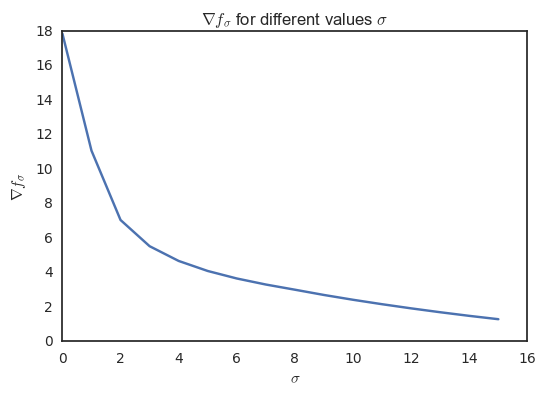

In [54]:
r_max = 16*3
w_, h_ = f.shape
w_ -= r_max
h_ -= r_max

# only consider the part of image that is valid
# after convolution with all kernel sizes
norm = lambda dxdf, dydf: np.sqrt((dxdf[0:w_, 0:h_]**2
                                 + dydf[0:w_, 0:h_]**2).sum())

norm_grad = zeros((16,))
norm_grad[0] = norm(*grad(f))

for sigma in range(1,16):
    w = gaussian_kernel(sigma)
    gf_sigma = grad(conv2d(f, w))
    norm_grad[sigma] = norm(*gf_sigma)

plot(range(16), norm_grad)
xlabel("$\sigma$")
ylabel("$\\nabla f_\sigma$")
title("$\\nabla f_\sigma$ for different values $\sigma$")
show()

## Exercise Sheet 2: Image Filtering by diffusion

Use the template file diffusion_filter.m for a nonlinear diffusion filter and complete the missing code at line 58. Test the script.

The key observation is that image smoothing can be
modeled with a diffusion process. In this process, the local
brightness diffuses to neighboring pixels due to
differences in the local concentration of grayvalue.

### Diffusion in Images

**Diffusion** is a physical process which aims at minimizing differences in the spatial concentration $u(x,t)$ of a substance.

- _Fick's law_ states the the flow $j$ is given as $j = -g\nabla u$, where $g$ describes the speed of the diffusion process
- The _continuity equation_: $\partial_t u = - \text{div} j$

This lead to the diffusion equation:

$$
\partial_t u = \text{div} (g \nabla u)
$$

### Implementation

The nonlinear diffusion equation is given as

$$
\partial_t u = \partial_x (g(\|\nabla u\|)\partial_x u) +
                \partial_y (g(\|\nabla u\|)\partial_y u)
$$

We use $\partial_t u \tilde{=} (u^{(t+\tau)} - u^{t}) / \tau$.



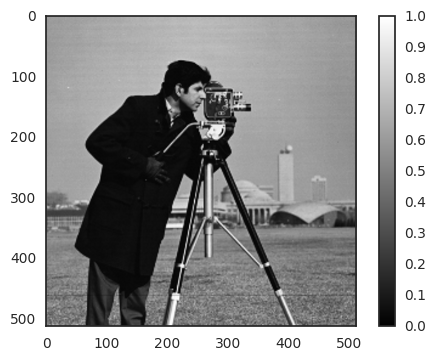

In [209]:
from skimage import data

f = data.camera() / 255.
imshow(f, cmap="gray")
colorbar()
show()

17.5006866455 % of pixels not affected
10.2561950684 % of pixels not affected
8.62312316895 % of pixels not affected
7.81021118164 % of pixels not affected
7.35549926758 % of pixels not affected
7.02171325684 % of pixels not affected
6.85081481934 % of pixels not affected
6.68106079102 % of pixels not affected
6.50596618652 % of pixels not affected
6.36749267578 % of pixels not affected


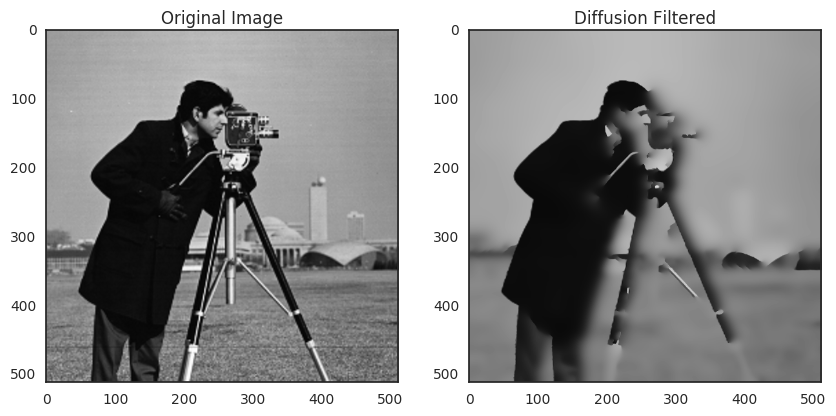

In [210]:
def diffusion_filter(J,method="pm1",N=1,K=1,dt=0.2, sigma2=0):
    """
     private function: diffusion (by Guy Gilboa, corrected by Thomas Brox):
     Jd=diffusion(J,method,N,K)
     Simulates N iterations of diffusion, parameters:
     J =  source image (2D gray-level matrix) for diffusio
     method =  'lin':  Linear diffusion (constant c=1).
               'pm1': perona-malik, c=exp{-(|grad(J)|/K)^2} [PM90]
               'pm2': perona-malik, c=1/{1+(|grad(J)|/K)^2} [PM90]
     K    edge threshold parameter
     N    number of iterations
     dt   time increment (0 < dt <= 0.25, default 0.2)
    
    References:
    ----------
    
     [PM90] P. Perona, J. Malik, "Scale-space and edge detection using anisotropic diffusion", PAMI 12(7), pp. 629-639, 1990. 
     [CLMC92] F. Catte, P. L. Lions, J. M. Morel and T. Coll, "Image selective smoothing and edge detection by nonlinear diffusion", SIAM J. Num. Anal., vol. 29, no. 1, pp. 182-193, 1992.
     [GSZ01] G. Gilboa, N. Sochen, Y. Y. Zeevi, "Complex Diffusion Processes for Image Filtering", Scale-Space 2001, LNCS 2106, pp. 299-307, Springer-Verlag 2001.
    """

    Nx,Ny = J.shape
    J_t = np.zeros((N+1,) + J.shape)
    
    for i in range(N):
        J_t[i] = J
        
        # calculate gradient magnitude for diffusivities
        
        Iy= (np.vstack([J[0:1,:],   J[:-1,:]]) - np.vstack([J[1:,:],  J[-2:-1,:]]))/2
        Ix= (np.hstack([J[:,1:],  J[:,-2:-1]])-np.sqrt(np.hstack([J[:,0:1], J[:,:-1]])))/2;
        
        D= (Ix*Ix)+(Iy*Iy)
        
        #imshow(D, cmap="gray")
        #colorbar()
        #title("D")
        #show()

        # calculate diffusivities
        if method   == 'lin': G=ones_like(J)
        elif method == 'pm1': G=np.exp(-(D/K**2))
        elif method == 'pm2': G=1./(1+(D/K**2))
        else: raise ValueError('Unknown method ' + method)
        
        if i % (N//10) == 0:
            #imshow(G < K, cmap="gray", vmin=0, vmax=1)
            #colorbar()
            #title("G")
            #show()
            print((G < K).mean()*100, "% of pixels not affected")

        # calculate one-sided differences
        In = np.vstack([J[0:1,:],   J[:-1,:]])  - J # i+1
        Is = np.vstack([J[1:,:],  J[-2:-1,:]])  - J # i-1
        Ie = np.hstack([J[:,1:],  J[:,-2:-1]])  - J # j+1
        Iw = np.hstack([J[:,0:1],   J[:,:-1]])  - J # j-1
        
        Gn = np.sqrt(np.vstack([G[0:1,:], G[:-1,:]])    * G)
        Gs = np.sqrt(np.vstack([G[1:,:],  G[-2:-1,:]])  * G)
        Ge = np.sqrt(np.hstack([G[:,1:],  G[:,-2:-1]])  * G)
        Gw = np.sqrt(np.hstack([G[:,0:1], G[:,:-1]])    * G)
        
        dJ = In * Gn + Is * Gs + Ie * Ge + Iw * Gw

        #imshow(dJ)
        #show()

        J = J + dt * dJ

        # Supplement code here
    J_t[-1] = J
    
    return J, J_t

figure(figsize=(10, 20))
Jd, J_t = diffusion_filter(f, N=1000, K=0.07, dt=0.25)

subplot(1,2,1)
imshow(f, cmap="gray")
title("Original Image")

subplot(1,2,2)
imshow(Jd, cmap="gray", vmin=0, vmax=1)
title("Diffusion Filtered")
show()

### Creating a video of the result

In [ ]:
import matplotlib.animation as animation
import numpy as np
from pylab import *

dpi = 50

def frames2vid(frames):
    """
    http://stackoverflow.com/questions/4092927/generating-movie-from-python-without-saving-individual-frames-to-files
    """
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_aspect('equal')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    im = ax.imshow(frames[0],cmap='gray',interpolation='nearest')
    im.set_clim([0,1])
    fig.set_size_inches([5,5])

    tight_layout()
    
    def update_img(n):
        im.set_data(frames[n,...])
        return im

    #legend(loc=0)
    ani = animation.FuncAnimation(fig,update_img,len(frames),interval=30)
    writer = animation.writers['ffmpeg'](fps=30)

    ani.save('camera.mp4',writer=writer,dpi=dpi)
    return ani

ani = frames2vid(J_t)